In [172]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, Matern
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import norm
import scipy



import matplotlib.pyplot as plt

In [174]:

# Load the data
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')
df_train = df[:22000]
df_test = df[22000:]

# Filter the training and test data
# query = 'odor>2'
# df_train = df_train.query(query)
# df_train.reset_index(inplace=True, drop=True)
# df_test = df_test.query(query)
# df_test.reset_index(inplace=True, drop=True)

# Function to fit an exponential distribution to the data below a threshold
def fit_exponential_distribution(far_data, threshold):
    non_saturated_data = far_data[far_data['odor'] < threshold]['odor']
    loc, scale = stats.expon.fit(non_saturated_data)
    return loc, scale

# Generate values above a threshold using an exponential distribution
def generate_values_above_threshold(loc, scale, threshold, size):
    cdf_threshold = stats.expon.cdf(threshold, loc=loc, scale=scale)
    uniform_values = np.random.uniform(cdf_threshold, 1, size)
    values_above_threshold = stats.expon.ppf(uniform_values, loc=loc, scale=scale)
    return values_above_threshold

# Replace saturated values in the data with estimated values from an exponential distribution
def estimate_values_with_exponential_distribution(df, threshold, loc, scale):
    saturated_indices = df[df['odor'] >= threshold].index
    estimated_values = generate_values_above_threshold(loc, scale, threshold, len(saturated_indices))
    df.loc[saturated_indices, 'odor'] = estimated_values
    return df

# Copy the train data
df_extracted = df_train.copy()

# Set thresholds
far_distance_threshold = 10
saturation_threshold = 10

# Fit exponential distribution to the training data for correction
far_data = df_extracted[df_extracted['distance_along_streakline'] > far_distance_threshold]
loc, scale = fit_exponential_distribution(far_data, saturation_threshold)

# Apply the correction to the training data
df_corrected = estimate_values_with_exponential_distribution(df_extracted.copy(), saturation_threshold, loc, scale)


whiff_threshold = 1  # Define a threshold for whiff initiation
df_corrected['whiff_initiation'] = (df_corrected['odor'] >= whiff_threshold).astype(int)

# Prepare features and binary target for training
X = df_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
y = df_corrected['whiff_initiation'].values



In [175]:
print(df_corrected['whiff_initiation'].value_counts())

0    17708
1     4292
Name: whiff_initiation, dtype: int64


In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

grid_size=80
# Step 2: Create a finer grid over the input feature space
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),  # 200 points for smaller grid
                     np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))  # 200 points for smaller grid
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Step 3: Scale the grid points
grid_points_scaled = scaler.transform(grid_points)

# Step 4: Predict the probabilities for each grid point using the trained model
grid_probabilities = rf.predict_proba(grid_points_scaled)[:, 1]

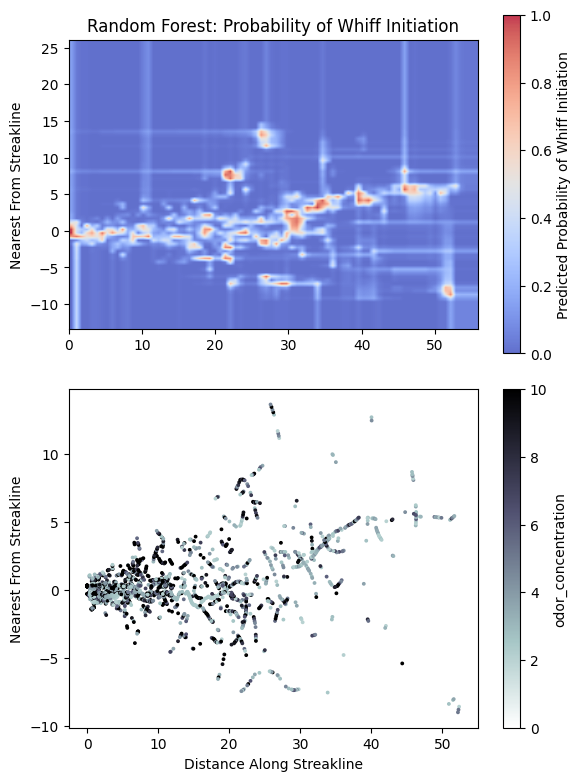

In [206]:
fig, ax = plt.subplots(2,1,figsize=(6, 8))
# cax = ax.contourf(xx, yy, grid_probabilities.reshape(xx.shape), cmap='coolwarm', alpha=0.8,  vmin=0,vmax=1)
# cax = ax.imshow(grid_probabilities.reshape(xx.shape), origin='lower',
#                 extent=[X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()],
#                 cmap='coolwarm', alpha=0.8, vmin=0, vmax=1, interpolation='bilinear')  # interpolation='bilinear' smooths the heatmap

grid_probabilities_reshaped = grid_probabilities.reshape(xx.shape)

cax = ax[0].imshow(grid_probabilities_reshaped, origin='lower', extent=[X[:, 0].min(), X[:, 0].max(),
                                                                     X[:, 1].min(), X[:, 1].max()],
                cmap='coolwarm', alpha=0.8, vmin=0, vmax=1, interpolation='bilinear')  # Apply interpolation='bilinear'



plt.colorbar(cax, label='Predicted Probability of Whiff Initiation')
# ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')

ax[0].set_title('Random Forest: Probability of Whiff Initiation')
# ax[0].set_xlabel('Distance Along Streakline')
ax[0].set_ylabel('Nearest From Streakline')

cax2 = ax[1].scatter(dftrain.distance_along_streakline, dftrain.nearest_from_streakline, c=dftrain.odor, cmap='bone_r', s=3, vmin=0, vmax=10)
plt.colorbar(cax2, label='odor_concentration')

# ax[1].set_title('Odor')
ax[1].set_xlabel('Distance Along Streakline')
ax[1].set_ylabel('Nearest From Streakline')

fig.tight_layout()

In [9]:
# Prepare the test data
new_test_df = df_test.copy()
new_test_df.reset_index(inplace=True, drop=True)

# Apply the correction to the test data
new_test_corrected = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)

# Prepare the test features
new_X_test = new_test_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
new_X_test_scaled = scaler.transform(new_X_test)

# Make predictions for the test set
whiff_probabilities = gpc.predict_proba(new_X_test_scaled)  # Get the probabilities for both classes
whiff_predictions = gpc.predict(new_X_test_scaled)  # Get binary predictions (0 or 1)

# Add predictions to the test dataframe
new_test_df['whiff_initiation'] = (new_test_df['odor'] >= whiff_threshold).astype(int)
new_test_df['whiff_predictions'] = whiff_predictions

# Evaluate the model using accuracy, confusion matrix, and classification report
print("Accuracy:", accuracy_score(new_test_df['whiff_initiation'], whiff_predictions))
print("Confusion Matrix:\n", confusion_matrix(new_test_df['whiff_initiation'], whiff_predictions))
print("Classification Report:\n", classification_report(new_test_df['whiff_initiation'], whiff_predictions))

Accuracy: 0.5602409638554217
Confusion Matrix:
 [[ 22 193]
 [ 26 257]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.10      0.17       215
           1       0.57      0.91      0.70       283

    accuracy                           0.56       498
   macro avg       0.51      0.51      0.43       498
weighted avg       0.52      0.56      0.47       498



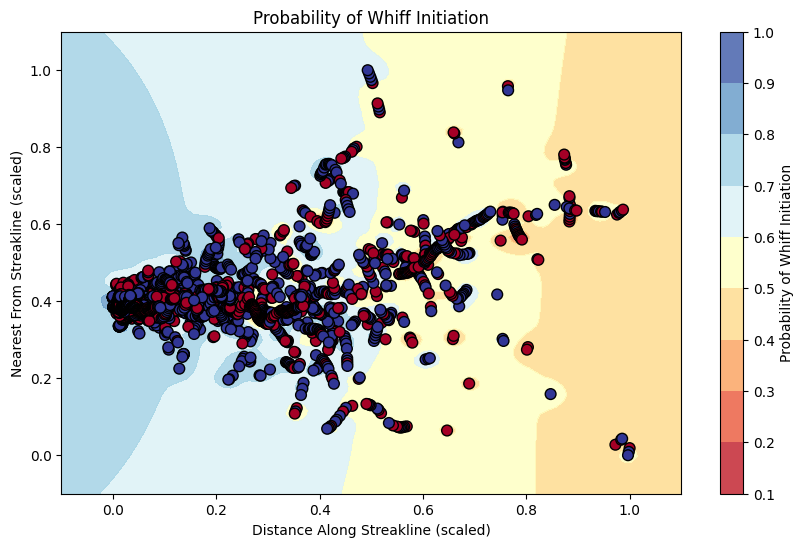

In [16]:
# Create a grid of points over the input feature space
x_min, x_max = X_scaled[:, 0].min() - 0.1, X_scaled[:, 0].max() + 0.1
y_min, y_max = X_scaled[:, 1].min() - 0.1, X_scaled[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to pass into the classifier
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the probability of whiff initiation at each point on the grid
probabilities = gpc.predict_proba(grid)[:, 1]  # Class 1 is whiff initiation

# Reshape the probabilities back to match the grid
probabilities = probabilities.reshape(xx.shape)

# Plot the probability of whiff initiation as a heatmap
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, probabilities, cmap='RdYlBu', alpha=0.8)
plt.colorbar(label='Probability of Whiff Initiation')

# Optionally, plot the training points as well
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='RdYlBu', edgecolor='k', s=60)
plt.title('Probability of Whiff Initiation')
plt.xlabel('Distance Along Streakline (scaled)')
plt.ylabel('Nearest From Streakline (scaled)')
plt.show()

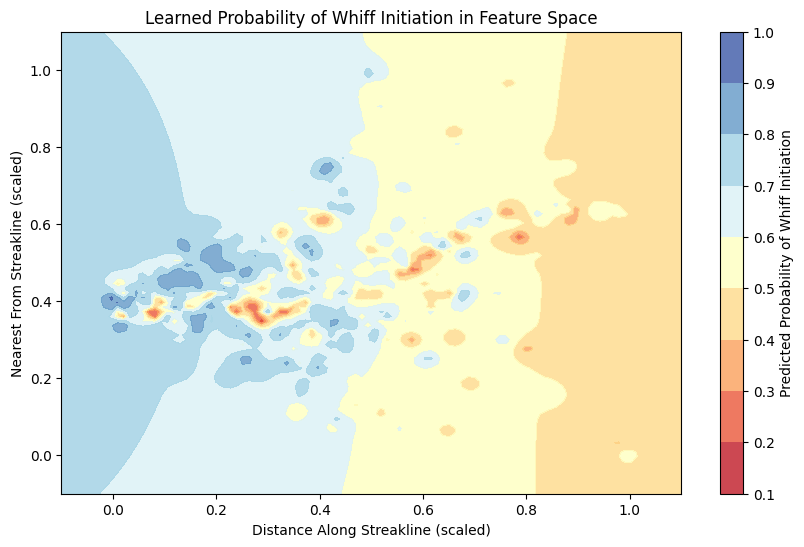

In [24]:
x_min, x_max = X_scaled[:, 0].min() - 0.1, X_scaled[:, 0].max() + 0.1
y_min, y_max = X_scaled[:, 1].min() - 0.1, X_scaled[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to pass into the classifier
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predict the probability of whiff initiation at each point on the grid
predicted_probabilities = gpc.predict_proba(grid_points)[:, 1]  # Class 1 probabilities (whiff initiation)

# Reshape the probabilities back to match the grid
probabilities_reshaped = predicted_probabilities.reshape(xx.shape)

# Create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the probability of whiff initiation as a heatmap
contour = ax.contourf(xx, yy, probabilities_reshaped, cmap='RdYlBu', alpha=0.8)
fig.colorbar(contour, ax=ax, label='Predicted Probability of Whiff Initiation')

# Set titles and labels
ax.set_title('Learned Probability of Whiff Initiation in Feature Space')
ax.set_xlabel('Distance Along Streakline (scaled)')
ax.set_ylabel('Nearest From Streakline (scaled)')

# Show the plot
plt.show()

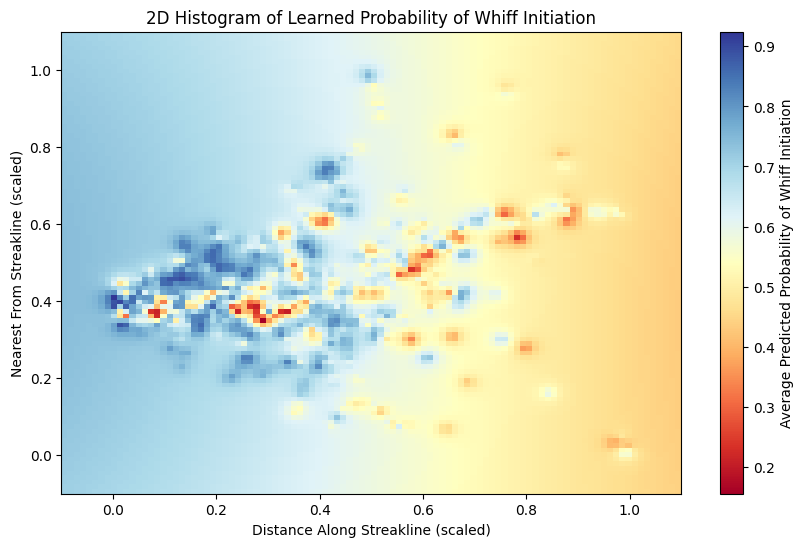

In [25]:
# Create a grid of points over the input feature space
x_min, x_max = X_scaled[:, 0].min() - 0.1, X_scaled[:, 0].max() + 0.1
y_min, y_max = X_scaled[:, 1].min() - 0.1, X_scaled[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to pass into the classifier
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predict the probability of whiff initiation at each point on the grid
predicted_probabilities = gpc.predict_proba(grid_points)[:, 1]  # Class 1 probabilities (whiff initiation)

# Create the figure and axis for the 2D histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot a 2D histogram using predicted probabilities over the grid points
hb = ax.hist2d(xx.ravel(), yy.ravel(), bins=100, weights=predicted_probabilities, cmap='RdYlBu')

# Add a colorbar to show the mapping of probabilities to color
fig.colorbar(hb[3], ax=ax, label='Average Predicted Probability of Whiff Initiation')

# Set titles and labels
ax.set_title('2D Histogram of Learned Probability of Whiff Initiation')
ax.set_xlabel('Distance Along Streakline (scaled)')
ax.set_ylabel('Nearest From Streakline (scaled)')

# Show the plot
plt.show()


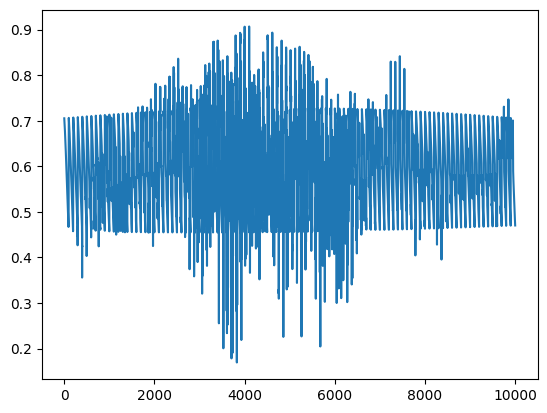

In [72]:
plt.plot(predicted_probabilities)

Text(0, 0.5, 'Nearest From Streakline')

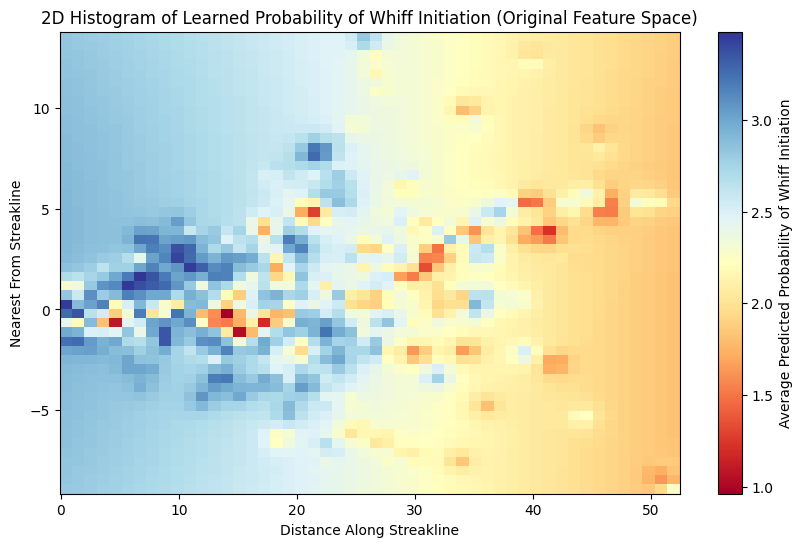

In [74]:
x_min, x_max = df_corrected['distance_along_streakline'].min() - 0.1, df_corrected['distance_along_streakline'].max() + 0.1
y_min, y_max = df_corrected['nearest_from_streakline'].min() - 0.1, df_corrected['nearest_from_streakline'].max() + 0.1

# Create a grid of points over the original input feature space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Flatten the grid to pass into the classifier
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Scale the grid points using the scaler that was used during training
grid_points_scaled = scaler.transform(grid_points)

# # Predict the probability of whiff initiation at each point on the grid
# predicted_probabilities = gpc.predict_proba(grid_points_scaled)[:, 1]  # Class 1 probabilities (whiff initiation)

# Create the figure and axis for the 2D histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot a 2D histogram using predicted probabilities over the grid points in original feature space
hb = ax.hist2d(xx.ravel(), yy.ravel(), bins=50, weights=predicted_probabilities, cmap='RdYlBu')

# Add a colorbar to show the mapping of probabilities to color
fig.colorbar(hb[3], ax=ax, label='Average Predicted Probability of Whiff Initiation')

# Set titles and labels
ax.set_title('2D Histogram of Learned Probability of Whiff Initiation (Original Feature Space)')
ax.set_xlabel('Distance Along Streakline')
ax.set_ylabel('Nearest From Streakline')


Text(0, 0.5, 'Nearest From Streakline')

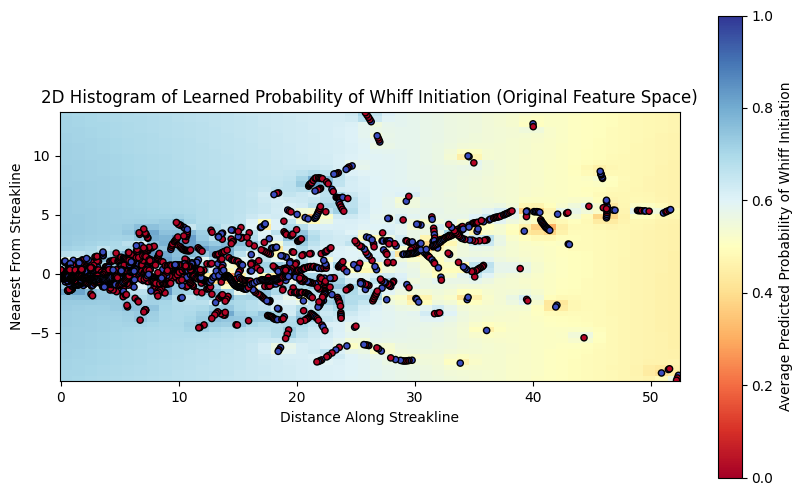

In [42]:
from scipy.stats import binned_statistic_2d

# Create the grid for the original feature space
x_min, x_max = df_corrected['distance_along_streakline'].min() - 0.1, df_corrected['distance_along_streakline'].max() + 0.1
y_min, y_max = df_corrected['nearest_from_streakline'].min() - 0.1, df_corrected['nearest_from_streakline'].max() + 0.1

# Generate the grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Scale the grid points using the trained scaler
grid_points_scaled = scaler.transform(grid_points)

# Predict probabilities
predicted_probabilities = gpc.predict_proba(grid_points_scaled)[:, 1]

# Calculate the mean of predicted probabilities in each bin
stat, x_edge, y_edge, _ = binned_statistic_2d(xx.ravel(), yy.ravel(), predicted_probabilities, statistic='mean', bins=50)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
c = ax.imshow(stat.T, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='RdYlBu', vmin=0, vmax=1)
fig.colorbar(c, ax=ax, label='Average Predicted Probability of Whiff Initiation')
ax.scatter(df_corrected['distance_along_streakline'], df_corrected['nearest_from_streakline'], c=df_corrected['whiff_initiation'], cmap='coolwarm', edgecolor='k', s=20)

# Set labels and title
ax.set_title('2D Histogram of Learned Probability of Whiff Initiation (Original Feature Space)')
ax.set_xlabel('Distance Along Streakline')
ax.set_ylabel('Nearest From Streakline')


In [43]:
X = df_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
y = df_corrected['whiff_initiation'].values  # Binary labels: 0 (no whiff) or 1 (whiff)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2. Define the kernel for Gaussian Process Regressor (you can tweak this)
kernel = C(0.814**2, (1e-2, 1e2)) * (RBF(0.05, (1e-2, 1e1)) + Matern(length_scale=0.05, nu=0.5))

# 3. Train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.263, n_restarts_optimizer=3)
gpr.fit(X_scaled, y)




Accuracy: 0.6782449725776966
Confusion Matrix:
 [[   0  704]
 [   0 1484]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       704
           1       0.68      1.00      0.81      1484

    accuracy                           0.68      2188
   macro avg       0.34      0.50      0.40      2188
weighted avg       0.46      0.68      0.55      2188



/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [51]:
# 4. Predict continuous outputs using GPR
y_pred_mean, y_pred_std = gpr.predict(X_scaled, return_std=True)

# 5. Apply the sigmoid function to convert the continuous output to probabilities
probabilities = expit(y_pred_mean)  # Sigmoid function maps to [0, 1]

# Optional: You can apply a threshold to convert probabilities to binary predictions
threshold = 0.01
binary_predictions = (probabilities >= threshold).astype(int)

# Evaluate using the binary predictions
print("Accuracy:", accuracy_score(y, binary_predictions))
print("Confusion Matrix:\n", confusion_matrix(y, binary_predictions))
print("Classification Report:\n", classification_report(y, binary_predictions))

Accuracy: 0.6782449725776966
Confusion Matrix:
 [[   0  704]
 [   0 1484]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       704
           1       0.68      1.00      0.81      1484

    accuracy                           0.68      2188
   macro avg       0.34      0.50      0.40      2188
weighted avg       0.46      0.68      0.55      2188



/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gorilla/An/arunavanag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

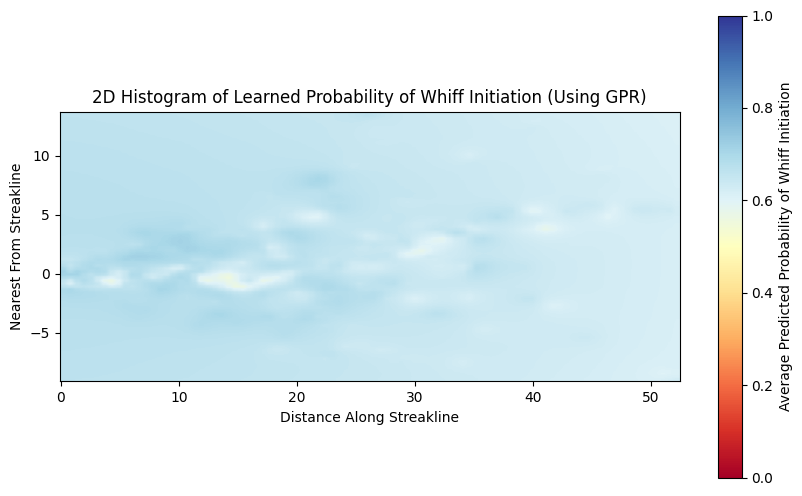

In [55]:

# 7. Visualize the probability of whiff initiation using a 2D histogram
x_min, x_max = df_corrected['distance_along_streakline'].min() - 0.1, df_corrected['distance_along_streakline'].max() + 0.1
y_min, y_max = df_corrected['nearest_from_streakline'].min() - 0.1, df_corrected['nearest_from_streakline'].max() + 0.1

# Create a grid of points over the original input feature space
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Scale the grid points using the same scaler
grid_points_scaled = scaler.transform(grid_points)

# Predict the probabilities on the grid using GPR
y_grid_mean, y_grid_std = gpr.predict(grid_points_scaled, return_std=True)
grid_probabilities = expit(y_grid_mean)  # Convert to probabilities using sigmoid

# 8. Plot the results as a 2D histogram
from scipy.stats import binned_statistic_2d

# Calculate the mean of predicted probabilities in each bin
stat, x_edge, y_edge, _ = binned_statistic_2d(xx.ravel(), yy.ravel(), grid_probabilities, statistic='mean', bins=90)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
c = ax.imshow(stat.T, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='RdYlBu', vmin=0, vmax=1)
fig.colorbar(c, ax=ax, label='Average Predicted Probability of Whiff Initiation')

# # Overlay the actual training data points
# ax.scatter(df_corrected['distance_along_streakline'], df_corrected['nearest_from_streakline'], 
#            c=df_corrected['whiff_initiation'], cmap='coolwarm', edgecolor='k', s=20)

ax.set_title('2D Histogram of Learned Probability of Whiff Initiation (Using GPR)')
ax.set_xlabel('Distance Along Streakline')
ax.set_ylabel('Nearest From Streakline')

plt.show()


In [56]:
print(df_corrected['whiff_initiation'].value_counts())


1    1484
0     704
Name: whiff_initiation, dtype: int64
